# <center>**Resolución Trabajo Práctico Número 2**</center>

#### <center>Visión por computadoras I - CEIA, Fiuba</center>

---

**Alumnas:**

- Espínola, Carla
- Gambarte, Antonella Nerea

---


## Imports


In [1]:
!pip install opencv-python-headless

In [2]:
import os
import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

import cv2

## Parte 1


1. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.


In [3]:
path = "/content/drive/MyDrive/Maestría/06 - Visión por computadora/white_patch"

In [4]:
def read_image(path: str) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    return np.asarray(img, dtype=np.float32)

def to_image(arr: np.ndarray) -> Image.Image:
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    return Image.fromarray(arr, mode="RGB")

def white_patch(img: np.ndarray, percentile: float = 100.0) -> np.ndarray:
    """
    White Patch escala cada canal para que el percentil seleccionado sea igual a 255.
    """
    out = img.copy()
    for c in range(3):
        channel = out[..., c]
        ref = np.percentile(channel, percentile) if percentile < 100 else channel.max()
        if ref <= 1e-6:
            gain = 1.0
        else:
            gain = 255.0 / ref
        out[..., c] = channel * gain
    return np.clip(out, 0, 255)

def cargar_imagenes(input_folder: str, output_folder: str, percentile: float = 100.0):
    os.makedirs(output_folder, exist_ok=True)
    exts = ("*.jpg", "*.png")
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(input_folder, e)))
    if not files:
        raise FileNotFoundError("No se encontraron imágenes en " + input_folder)
    records = []
    for path in sorted(files):
        img = read_image(path)
        corrected = white_patch(img, percentile=percentile)
        base = os.path.splitext(os.path.basename(path))[0]
        out_path = os.path.join(output_folder, f"{base}_whitepatch.png")
        to_image(corrected).save(out_path, format="PNG")
        records.append({"input": path, "output": out_path, "percentile": percentile})
    return records

def visualizar_imagenes(preview_count,records):
  for i in range(preview_count):
    rec = records[i]
    before = np.asarray(Image.open(rec["input"]).convert("RGB"))
    after = np.asarray(Image.open(rec["output"]).convert("RGB"))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(before)
    plt.axis("off")
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(after)
    plt.axis("off")
    plt.title("White Patch")
    plt.show()

2. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de
   White patch.


In [5]:
input_dir = path
output_dir = path + "_corrected"
percentile = 99.0
records = cargar_imagenes(input_dir, output_dir, percentile=percentile)
preview_count = min(10, len(records))

visualizar_imagenes(preview_count,records)

FileNotFoundError: No se encontraron imágenes en /content/drive/MyDrive/Maestría/06 - Visión por computadora/white_patch

/tmp/ipython-input-817089059.py:7: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="RGB")


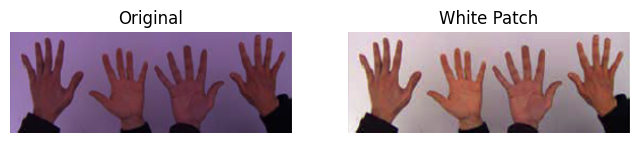

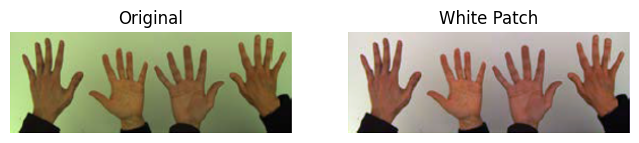

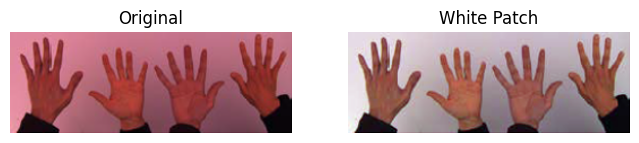

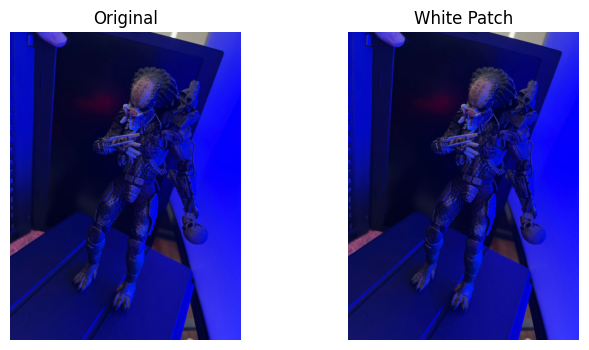

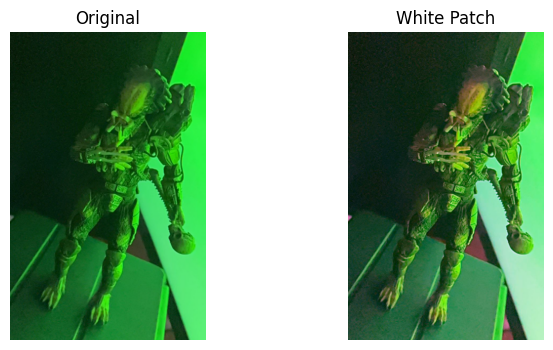

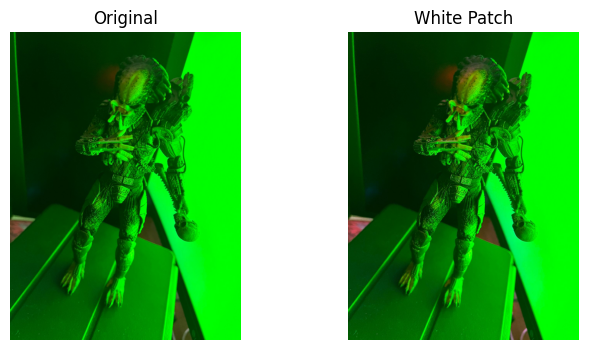

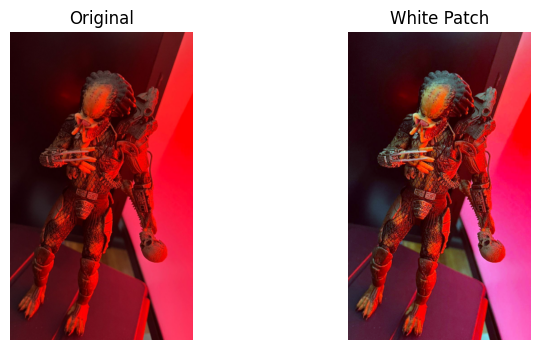

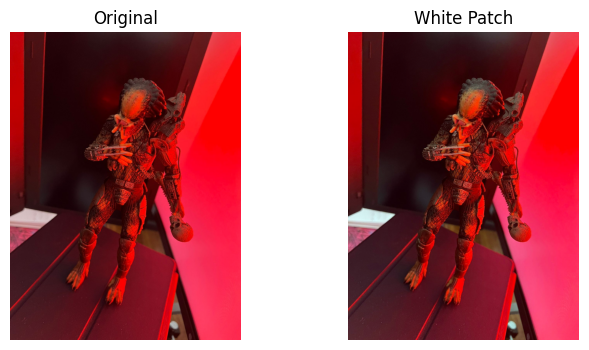

In [ ]:
percentile = 100.0
records = cargar_imagenes(input_dir, output_dir, percentile=percentile)
preview_count = min(10, len(records))

visualizar_imagenes(preview_count,records)

- Las imágenes wp_green2.png y wp_red2.png están más saturadas.
- El color rojo y el azul parecen recuperarse mejor.
- Usar un percentil menor a 100 (como 95) hace que el algoritmo sea más resistente a las altas luces saturadas. En 100 la mayoría de las imágenes wp no se logran corregir las diferencias de color.
- La imagen wp_green2.png se sobresatura en el color rojo y se ve más el fuscia que blanco.
- Usando un percentile de 99 aparece un tono verdoso en la imagen wp_red.png.


## Parte 2


1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y
   visualizarlas.


In [ ]:
path_base = "/content/drive/MyDrive/Maestría/06 - Visión por computadora/"

def read_grayscale(path: str):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

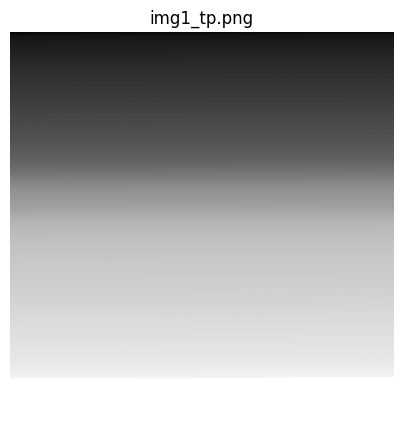

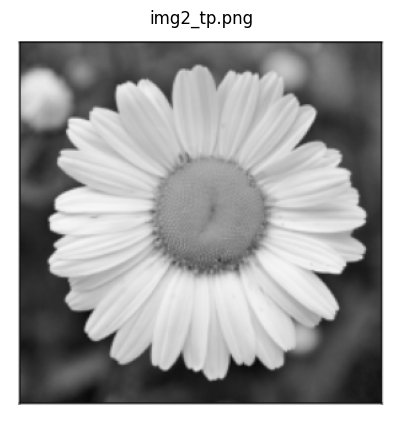

In [ ]:
names = ["img1_tp.png", "img2_tp.png"]

for n in names:
    p = path_base + n
    img = read_grayscale(p)
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"{n}")
    plt.show()


2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas
   entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección
   de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?


/tmp/ipython-input-799839614.py:10: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img.ravel(), num_bins, [0, 256])


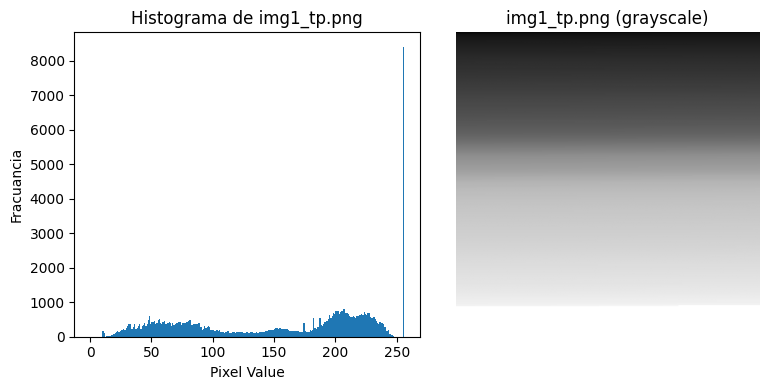

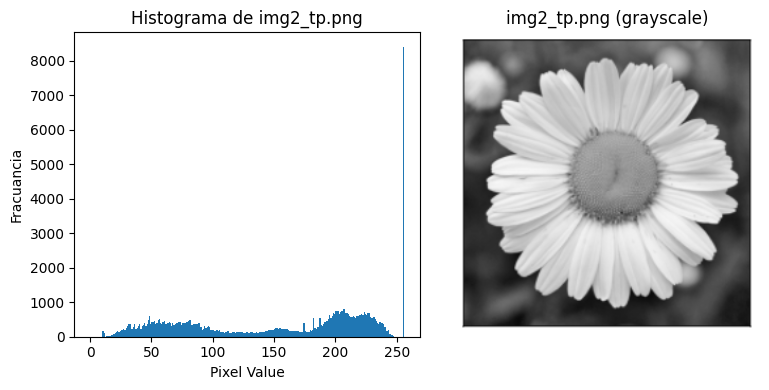

In [ ]:
num_bins = 256

for n in names:
    p = path_base + n
    img = read_grayscale(p)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.hist(img.ravel(), num_bins, [0, 256])
    plt.title(f"Histograma de {n}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Fracuancia")

    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"{n} (grayscale)")

    plt.tight_layout()
    plt.show()

En los hostogramas se observa que se puede tener 2 imágenes con igual distribución de intensidad, pero que la relación espacial determine una imagen completamente distinta en cada caso.

Utilizar solo los histogramas como features llevaría al modelo a entender que las 2 imágenes son la misma. Esto puede ser una desventaja importante para tareas que dependen del reconocimiento de formas, objetos o relaciones espaciales. Por otro lado, para tareas complejas de clasificación o detección, saber la distribución de intensidad no es suficiente para poder discriminar y distinguir entre diferentes clases u objetos.

Sin embargo, si los histogramas se agregan como información a las features que capturan la información espacial, esta información puede ser muy útil debido a que:

- Son relativamente robustos a los cambios en la iluminación. Si el brillo general de una imagen cambia, el histograma se desplazará, pero la forma de la distribución podría permanecer similar. Esto puede ser útil para tareas donde las condiciones de iluminación varían.
- Tener un resumen de la distribución de intensidad de una imagen puede ser una característica distintiva para ciertos tipos de imágenes. Por ejemplo, las imágenes de texturas pueden tener formas de histograma diferentes a las imágenes de superficies lisas.
